# Test Analystic GLRT vs Optimization GLRT

In [1]:
# Comparing the analytic GLRT for the single-coefficient case with the optimization-based version
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
from uncertainty.DataGeneration import linearRegression_normal
from uncertainty.torch_linear import TorchLinear
from uncertainty.analyticLinearRegressionCIs import analyticLinearTest_GLRT, analyticLinearCis
from uncertainty.glrtTorch import glrtTorchCis
from uncertainty.torch_linear import TorchLinear

In [8]:
def compareAnalyticVsOptimization(beta, n=200, alpha=0.05):
    """Generate data according to a linear regression with coefficient vector beta.
    Compute the analytic chi-squared test 'is the coefficient vector zero?'. Record the p-value.
    Compute the confidence intervals on beta using the GLRT-based method. Record whether ALL intervals contains zero.
    Return TRUE if both methods agree, and FALSE otherwise."""  
    # Get data
    X, y = linearRegression_normal(beta=np.array(beta), cov=np.eye(len(beta)), sigma=1, n=n)

    # Compute the p-value from the chi squared test
    TL = TorchLinear(lr=0.3,max_iter=30)
    TL.fit(X,y)
    pVal_TL = analyticLinearTest_GLRT(TL, X, y)
    
    # Next, get the optimization-based intervals.
    # GLRT method with Torch model (coefs)
    lcb_GLRT, ucb_GLRT, lcb_Results, ucb_Results, ucb_Torch = glrtTorchCis(
        lambda:TorchLinear(lr=0.3,max_iter=100,fit_intercept=False), X=X, y=y, citype='coefs', alpha=alpha,
        search_kwargs={'lmbds':np.logspace(-10,10,101)},fit_kwargs={'lr':0.3,'max_iter':30})
    
    # To check whether they agree with the analytic version:
    # The p-value should be < 0.05 iff any of the level-0.05 glrt-based confidence intervals
    # on the coefficient beta don't contain zero.
    isNotZero_analytic = pVal_TL < alpha    # The chi-square test is one-sided
    isNotZero_optim = any(lcb_GLRT > 0) or any(ucb_GLRT < 0)
    
    print("p value", pVal_TL, "and confidence interval(s)", lcb_GLRT, "to", ucb_GLRT)
    
    return (isNotZero_analytic == isNotZero_optim, pVal_TL, lcb_GLRT, ucb_GLRT)
    

## Single nonzero coefficient

In [9]:
%%time
beta = [0.1]

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.022285602035508556 and confidence interval [0.03723447] to [0.29411563]
p value 0.3055572904750059 and confidence interval [-0.06135622] to [0.22432308]
p value 0.016140062889988926 and confidence interval [0.04983376] to [0.3083584]
p value 0.03572538234954026 and confidence interval [0.0197282] to [0.24236403]
p value 0.057271863657080146 and confidence interval [0.01500111] to [0.23651956]
p value 0.00344452551998764 and confidence interval [0.08620236] to [0.33680105]
p value 0.053555109489299535 and confidence interval [0.02955844] to [0.23960735]
p value 0.34281536938680623 and confidence interval [-0.14899243] to [0.01725363]
p value 0.0608583694157907 and confidence interval [0.01384854] to [0.26430982]


KeyboardInterrupt: 

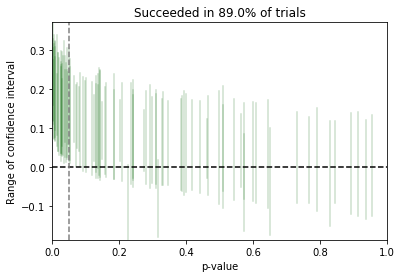

In [5]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Single Zero Coefficient

In [6]:
%%time
beta = [0.0]

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.010065697013278752 and confidence interval [-0.32121551] to [-0.05462781]
p value 0.38332014773572665 and confidence interval [-0.18513457] to [0.0566593]
p value 0.46933716149415605 and confidence interval [-0.17649673] to [0.07245571]
p value 0.40162140227533727 and confidence interval [-0.06663625] to [0.17793277]
p value 0.13307229248481245 and confidence interval [-0.01165634] to [0.20390682]
p value 0.9251746992055117 and confidence interval [-0.09618982] to [0.08314887]
p value 0.9492197278954458 and confidence interval [-0.13533084] to [0.14375989]
p value 0.6220876893032526 and confidence interval [-0.17182997] to [0.1003686]
p value 0.2971460329040737 and confidence interval [-0.05243973] to [0.20746814]
p value 0.7509762379159894 and confidence interval [-0.15082262] to [0.10511569]
p value 0.8686630493086943 and confidence interval [-0.1364222] to [0.11374637]
p value 0.12406568351362302 and confidence interval [-0.19133796] to [-0.02761748]
p value 0.694166183241

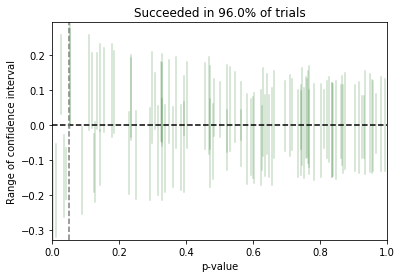

In [7]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Multi-dimensional Beta

In [11]:
%%time
beta = [0.0, 0.0]

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.050271022546787614 and confidence interval [-0.29817557 -0.09454879] to [-0.03955125  0.15933545]
p value 0.8001217906720733 and confidence interval [-0.09985401 -0.14450122] to [0.12487067 0.06337634]
p value 0.7333737699274101 and confidence interval [-0.10703277 -0.17237686] to [0.16734374 0.09043024]
p value 0.8460490223881125 and confidence interval [-0.08451132 -0.12857111] to [0.16819561 0.12207065]
p value 0.40465923843752327 and confidence interval [-0.06595258 -0.17624506] to [0.21786453 0.04567946]
p value 0.7701644916812802 and confidence interval [-0.1908652  -0.14513732] to [0.0821595  0.10654222]
p value 0.8632151204916283 and confidence interval [-0.09261773 -0.11892501] to [0.17402621 0.11631782]
p value 0.5477632012146414 and confidence interval [-0.07961259 -0.06547208] to [0.16545565 0.18943523]
p value 0.5228041377312096 and confidence interval [-0.16109771 -0.09710956] to [0.04891453 0.19305174]
p value 0.11885431895285514 and confidence interval [-0.233

KeyboardInterrupt: 

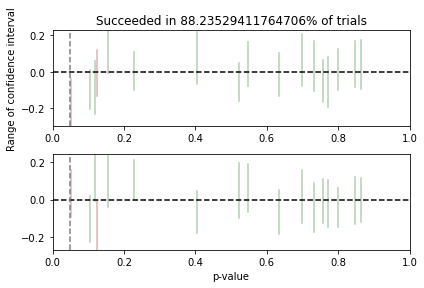

In [29]:
d = len(beta)
fig, ax = plt.subplots(d)
for i in range(d):
    ilcbs = [l[i] for l in lcbs]
    iucbs = [u[i] for u in ucbs]
    minY = min(ilcbs)
    maxY = max(iucbs)
    ax[i].set_ylim(minY, maxY)
    
    for (p, l, u, s) in zip(pVals, ilcbs, iucbs, success):
        # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
        ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                    color=('darkgreen' if s else 'darkred'), alpha=0.3)

    ax[i].axhline(0, color='k', linestyle='--')
    ax[i].axvline(0.05, color='gray', linestyle='--')
    
ax[0].set_title("Succeeded in " + str(np.mean(success)*100) + "% of trials")    
ax[d-1].set_xlabel("p-value")
ax[0].set_ylabel("Range of confidence interval")
plt.tight_layout()
plt.show()

## Higher dimensional beta - check for multiple testing problems (I don't think we will have them... but good to confirm)

In [ ]:
%%time
beta = [0.0, 0.0, 0.0, 0.0, 0.0]

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

In [ ]:
d = len(beta)
fig, ax = plt.subplots(d)
for i in range(d):
    ilcbs = [l[i] for l in lcbs]
    iucbs = [u[i] for u in ucbs]
    minY = min(ilcbs)
    maxY = max(iucbs)
    ax[i].set_ylim(minY, maxY)
    
    for (p, l, u, s) in zip(pVals, ilcbs, iucbs, success):
        # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
        ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                    color=('darkgreen' if s else 'darkred'), alpha=0.3)

    ax[i].axhline(0, color='k', linestyle='--')
    ax[i].axvline(0.05, color='gray', linestyle='--')
    
ax[0].set_title("Succeeded in " + str(np.mean(success)*100) + "% of trials")    
ax[d-1].set_xlabel("p-value")
ax[0].set_ylabel("Range of confidence interval")
plt.tight_layout()
plt.show()